In [28]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rio
from osgeo import gdal,osr
import rasterio
import os
from datetime import datetime, timedelta

from satpy import Scene
from pyorbital import astronomy
import glob 
import re

In [29]:
#BINARY IMAGE 0,1
file_binary = r"C:\Users\valentina\Desktop\Super_Resolution_Alexandroupoli\BINARY_IMAGE\output.tif"
binary_image = xr.open_dataset(file_binary)

binary_image = binary_image.squeeze('band')
#Delete coordinates band and spatial_ref
binary_image = binary_image.drop(['band','spatial_ref'])
#Rename Data variable to ndvi
binary_image = binary_image.rename({'band_data':'binary_image'})
binary_image

<xarray.Dataset>
Dimensions:       (x: 896, y: 706)
Coordinates:
  * x             (x) float64 19.35 19.36 19.37 19.38 ... 28.27 28.28 28.29 28.3
  * y             (y) float64 41.76 41.75 41.74 41.73 ... 34.73 34.72 34.71
Data variables:
    binary_image  (y, x) float32 ...

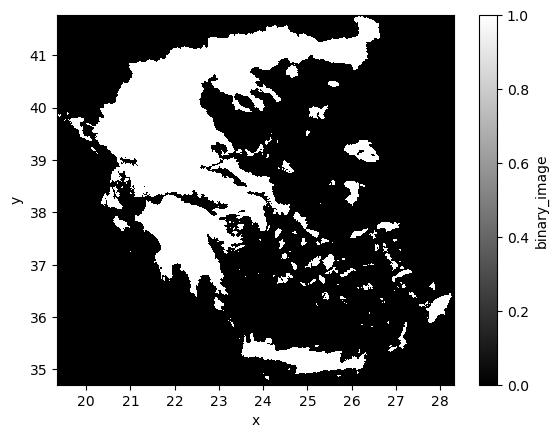

In [30]:
#BINARY IMAGE 0,1 PLOT
binary_image.binary_image.plot(cmap='gray')

In [31]:
import os
import cv2
from PIL import Image
import glob 
import matplotlib.pyplot as plt
from satpy.scene import Scene
from satpy.composites import GenericCompositor
from satpy.writers import to_image
from satpy.resample import get_area_def
from satpy import available_readers#scn.show('dust')
import xarray as xr
import numpy as np
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = plt.Axes.pcolormesh
import glob
from pyresample import create_area_def

In [61]:
#SEVIRI HRV CHANNEL
import os
import glob
import xarray as xr
import numpy as np


# Βρείτε όλα τα αρχεία NAT στον φάκελο
tif_files = glob.glob(r"C:\Users\valentina\Desktop\Super_Resolution_Alexandroupoli\*\*.nat")

result_list_sevirichannelHRV = []


custom_area = create_area_def('my_area', {'proj': 'longlat', 'lon_0': 0},
                              width=4176, height=5568,
                              area_extent=[19.35 ,34.70, 28.31 ,41.76], units='degrees')

# Εφαρμόστε τη διαδικασία για κάθε αρχείο TIFF
for tif_file in tif_files:
    
    scn = Scene(reader="seviri_l1b_native", filenames=[tif_file])
    scn.load(['HRV'])
    scn['HRV']
    # Επιλογή της μεταβλητής 'HRV'
    seviri_HRV = scn['HRV']
    # Επανονομασία της μεταβλητής σε 'seviri_cloud'
    seviri_HRV.name = 'seviri_HRV'
    seviri_HRV  = seviri_HRV.drop(['acq_time'])
    
    custom_scn = scn.resample(custom_area)
    
    #tif_date = re.split(r'[-\\_]', tif_file)[-3]
    tif_date = re.split(r'[-.\\_]', tif_file)[-4][-6:-2]

    # Εφαρμογή των ενεργειών για το κάθε seviri_cloud
    standard_image = binary_image
    seviri_channelHRV_inter = custom_scn['HRV'].interp(x=standard_image["x"], y=standard_image["y"], method='nearest')
    
    # Έλεγχος για την ισότητα των συντεταγμένων
    equal_x = np.array_equal(seviri_channelHRV_inter.x, standard_image.x)
    equal_y = np.array_equal(seviri_channelHRV_inter.y, standard_image.y)
    
    # Αντικατάσταση των τιμών όπου το standard_image δεν είναι 0
    seviri_channelHRV_inter_masked = seviri_channelHRV_inter.where(standard_image.binary_image!=0)
    
    # Επανενσωμάτωση και έλεγχος των συντεταγμένων
    seviri_channelHRV_inter_masked = seviri_channelHRV_inter_masked.interp(y=standard_image["y"], x=standard_image["x"], method='nearest')
    equal_x = np.array_equal(seviri_channelHRV_inter_masked.x, standard_image.x)
    equal_y = np.array_equal(seviri_channelHRV_inter_masked.y, standard_image.y)
    print(equal_x, equal_y)
    
    seviri_channelHRV_inter_masked = seviri_channelHRV_inter_masked.assign_attrs(date=tif_date)
    seviri_channelHRV_inter_masked = seviri_channelHRV_inter_masked.reindex(y=list(reversed(seviri_channelHRV_inter_masked.y)))

    seviri_channelHRV_inter_masked = seviri_channelHRV_inter_masked.rename('seviri_HRV')

    # Εμφάνιση του τελικού αποτελέσματος
    print(seviri_channelHRV_inter_masked)
    
    result_list_sevirichannelHRV.append(seviri_channelHRV_inter_masked)

True True
<xarray.DataArray 'seviri_HRV' (y: 706, x: 896)>
dask.array<getitem, shape=(706, 896), dtype=float32, chunksize=(706, 896), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 34.71 34.72 34.73 34.74 ... 41.73 41.74 41.75 41.76
  * x        (x) float64 19.35 19.36 19.37 19.38 ... 28.27 28.28 28.29 28.3
    crs      object GEOGCRS["unknown",DATUM["World Geodetic System 1984",ELLI...
Attributes: (12/21)
    orbital_parameters:                     {'projection_longitude': 9.5, 'pr...
    sun_earth_distance_correction_applied:  True
    sun_earth_distance_correction_factor:   1.0120745002905316
    units:                                  %
    wavelength:                             0.7 µm (0.5-0.9 µm)
    standard_name:                          toa_bidirectional_reflectance
    ...                                     ...
    resolution:                             1000.134348869
    calibration:                            reflectance
    modifiers:                    

C:\Users\valentina\anaconda3\Lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\valentina\anaconda3\Lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in sin
  return func(*(_execute_task(a, cache) for a in args))


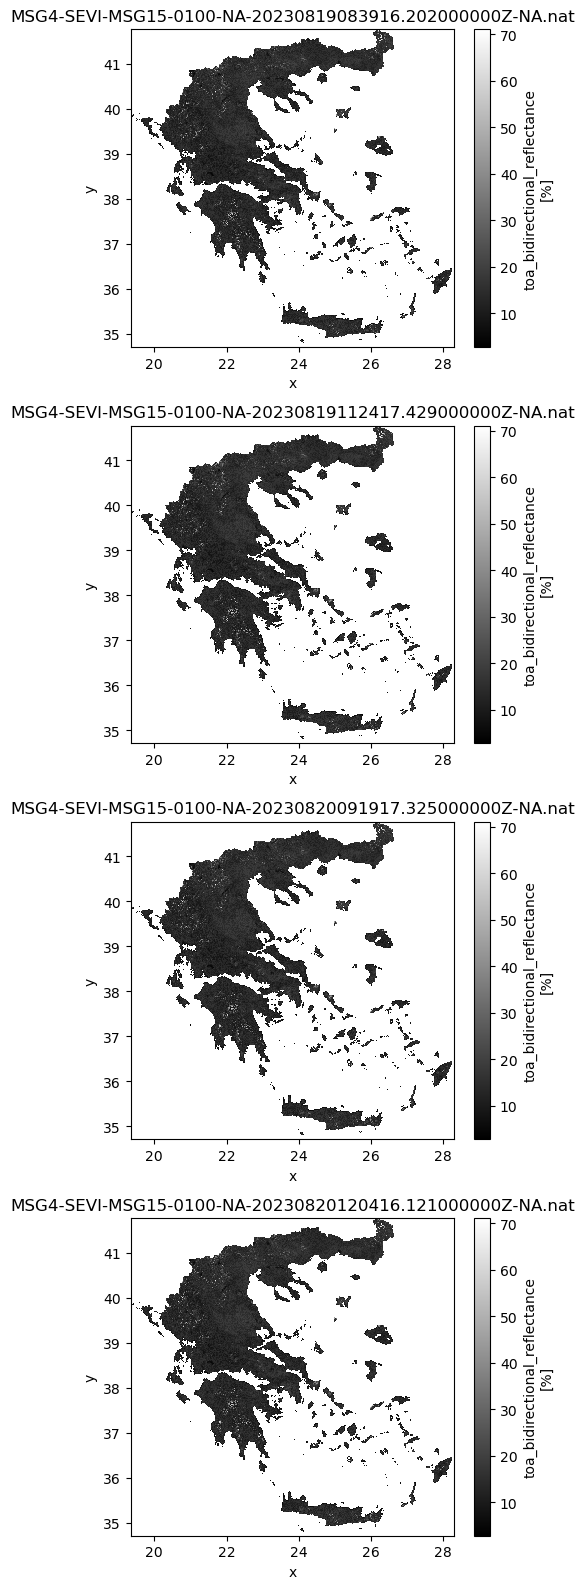

In [6]:
# Δημιουργία ενός πλοτ με όλες τις εικόνες
fig, axes = plt.subplots(len(tif_files), 1, figsize=(5, len(tif_files) * 4))

for idx, tif_file in enumerate(tif_files):
    # Εμφάνιση της εικόνας
    seviri_channelHRV_inter_masked.plot(ax=axes[idx], cmap='gray')
    
    # Προσαρμογή των τίτλων
    axes[idx].set_title(os.path.basename(tif_file))

plt.tight_layout()  # Αυτόματη προσαρμογή της διάταξης
plt.show()

In [36]:
#SEVIRI IMAGE CHANNEL 4
import os
import glob
import xarray as xr
import numpy as np

# Καθορίστε τον φάκελο που περιέχει τα αρχεία TIFF
image_seviri_channel4_folder = r"C:\Users\valentina\Desktop\Super_Resolution_Alexandroupoli\SEVIRI_IMAGES"

# Βρείτε όλα τα αρχεία TIFF στον φάκελο
tif_files = glob.glob(os.path.join(image_seviri_channel4_folder, "*.tif"))

result_list_sevirichannel4 = []

# Εφαρμόστε τη διαδικασία για κάθε αρχείο TIFF
for tif_file in tif_files:
    
    #tif_date = re.split(r'[-\\_]', tif_file)[-3]
    tif_date = re.split(r'[-\\_]', tif_file)[-3][-6:-2]

    # Ανοίξτε το αρχείο χρησιμοποιώντας την xarray
    seviri_channel4 = xr.open_dataset(tif_file)
    seviri_channel4 = seviri_channel4.isel(band=3)
    
    # Αφαιρέστε τη διάσταση 'band' και τη μεταβλητή 'spatial_ref'
    seviri_channel4 = seviri_channel4.drop(['band','spatial_ref'])
    
    # Μετονομάστε τη μεταβλητή 'band_data' σε 'seviri_cloud'
    seviri_channel4 = seviri_channel4.rename({'band_data':'seviri_channel4'})
    
    # Εφαρμογή των ενεργειών για το κάθε seviri_cloud
    standard_image = binary_image
    seviri_channel4_inter = seviri_channel4.interp(x=standard_image["x"], y=standard_image["y"], method='nearest')
    
    # Έλεγχος για την ισότητα των συντεταγμένων
    equal_x = np.array_equal(seviri_channel4_inter.x, standard_image.x)
    equal_y = np.array_equal(seviri_channel4_inter.y, standard_image.y)
    
    # Αντικατάσταση των τιμών όπου το standard_image δεν είναι 0
    seviri_channel4_inter_masked = seviri_channel4_inter.where(standard_image.binary_image!=0)
    
    # Επανενσωμάτωση και έλεγχος των συντεταγμένων
    seviri_channel4_inter_masked = seviri_channel4_inter_masked.interp(y=standard_image["y"], x=standard_image["x"], method='nearest')
    equal_x = np.array_equal(seviri_channel4_inter_masked.x, standard_image.x)
    equal_y = np.array_equal(seviri_channel4_inter_masked.y, standard_image.y)
    print(equal_x, equal_y)
    
    seviri_channel4_inter_masked = seviri_channel4_inter_masked.assign_attrs(date=tif_date)
    seviri_channel4_inter_masked = seviri_channel4_inter_masked.reindex(y=list(reversed(seviri_channel4_inter_masked.y)))

    # Εμφάνιση του τελικού αποτελέσματος
    print(seviri_channel4_inter_masked)
    
    result_list_sevirichannel4.append(seviri_channel4_inter_masked)

True True
<xarray.Dataset>
Dimensions:          (y: 706, x: 896)
Coordinates:
  * y                (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x                (x) float64 19.35 19.36 19.37 19.38 ... 28.28 28.29 28.3
Data variables:
    seviri_channel4  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    date:     0839
True True
<xarray.Dataset>
Dimensions:          (y: 706, x: 896)
Coordinates:
  * y                (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x                (x) float64 19.35 19.36 19.37 19.38 ... 28.28 28.29 28.3
Data variables:
    seviri_channel4  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    date:     1124
True True
<xarray.Dataset>
Dimensions:          (y: 706, x: 896)
Coordinates:
  * y                (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x                (x) float64 19.35 19.36 19.37 19.38 ... 28.28 28.29 28.3
Data variables:
    seviri_channel4  (y, 

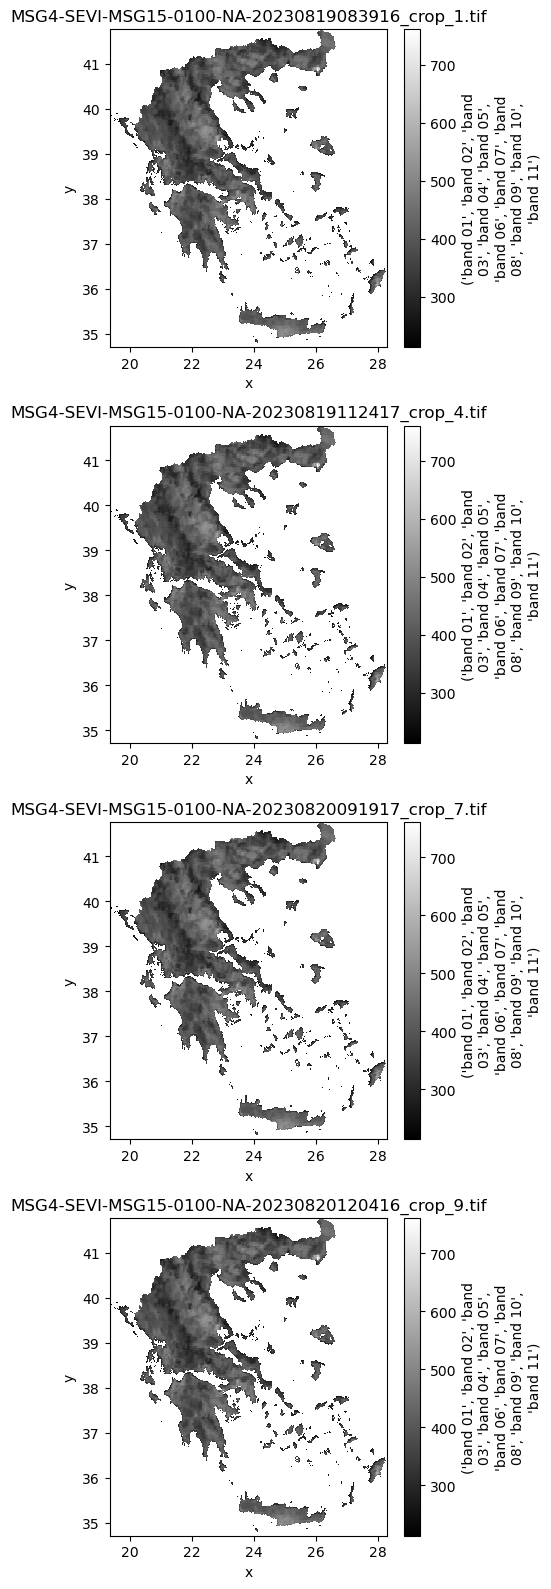

In [8]:
# Δημιουργία ενός πλοτ με όλες τις εικόνες
fig, axes = plt.subplots(len(tif_files), 1, figsize=(5, len(tif_files) * 4))

for idx, tif_file in enumerate(tif_files):
    # Εμφάνιση της εικόνας
    seviri_channel4_inter_masked.seviri_channel4.plot(ax=axes[idx], cmap='gray')
    
    # Προσαρμογή των τίτλων
    axes[idx].set_title(os.path.basename(tif_file))

plt.tight_layout()  # Αυτόματη προσαρμογή της διάταξης
plt.show()

In [37]:
#SEVIRI IMAGE CHANNEL 9
import os
import glob
import xarray as xr
import numpy as np

# Καθορίστε τον φάκελο που περιέχει τα αρχεία TIFF
image_seviri_channel9_folder = r"C:\Users\valentina\Desktop\Super_Resolution_Alexandroupoli\SEVIRI_IMAGES"

# Βρείτε όλα τα αρχεία TIFF στον φάκελο
tif_files = glob.glob(os.path.join(image_seviri_channel9_folder, "*.tif"))

#result_list_sevirichannel9 = []
result_list_sevirichannel9 = []

# Εφαρμόστε τη διαδικασία για κάθε αρχείο TIFF
for tif_file in tif_files:
    
    tif_date = re.split(r'[-\\_]', tif_file)[-3]

    # Ανοίξτε το αρχείο χρησιμοποιώντας την xarray
    seviri_channel9 = xr.open_dataset(tif_file)
    seviri_channel9 = seviri_channel9.isel(band=8)
    
    # Αφαιρέστε τη διάσταση 'band' και τη μεταβλητή 'spatial_ref'
    seviri_channel9 = seviri_channel9.drop(['band','spatial_ref'])
    
    # Μετονομάστε τη μεταβλητή 'band_data' σε 'seviri_cloud'
    seviri_channel9 = seviri_channel9.rename({'band_data':'seviri_channel9'})
    
    # Εφαρμογή των ενεργειών για το κάθε seviri_cloud
    standard_image = binary_image
    seviri_channel9_inter = seviri_channel9.interp(x=standard_image["x"], y=standard_image["y"], method='nearest')
    
    # Έλεγχος για την ισότητα των συντεταγμένων
    equal_x = np.array_equal(seviri_channel9_inter.x, standard_image.x)
    equal_y = np.array_equal(seviri_channel9_inter.y, standard_image.y)
    
    # Αντικατάσταση των τιμών όπου το standard_image δεν είναι 0
    seviri_channel9_inter_masked = seviri_channel9_inter.where(standard_image.binary_image!=0)
    
    # Επανενσωμάτωση και έλεγχος των συντεταγμένων
    seviri_channel9_inter_masked = seviri_channel9_inter_masked.interp(y=standard_image["y"], x=standard_image["x"], method='nearest')
    equal_x = np.array_equal(seviri_channel9_inter_masked.x, standard_image.x)
    equal_y = np.array_equal(seviri_channel9_inter_masked.y, standard_image.y)
    print(equal_x, equal_y)
    
    seviri_channel9_inter_masked = seviri_channel9_inter_masked.assign_attrs(date=tif_date)
    seviri_channel9_inter_masked = seviri_channel9_inter_masked.reindex(y=list(reversed(seviri_channel9_inter_masked.y)))

    # Εμφάνιση του τελικού αποτελέσματος
    print(seviri_channel9_inter_masked)
    
    result_list_sevirichannel9.append(seviri_channel9_inter_masked)


True True
<xarray.Dataset>
Dimensions:          (y: 706, x: 896)
Coordinates:
  * y                (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x                (x) float64 19.35 19.36 19.37 19.38 ... 28.28 28.29 28.3
Data variables:
    seviri_channel9  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    date:     20230819083916
True True
<xarray.Dataset>
Dimensions:          (y: 706, x: 896)
Coordinates:
  * y                (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x                (x) float64 19.35 19.36 19.37 19.38 ... 28.28 28.29 28.3
Data variables:
    seviri_channel9  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    date:     20230819112417
True True
<xarray.Dataset>
Dimensions:          (y: 706, x: 896)
Coordinates:
  * y                (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x                (x) float64 19.35 19.36 19.37 19.38 ... 28.28 28.29 28.3
Data variables:
    s

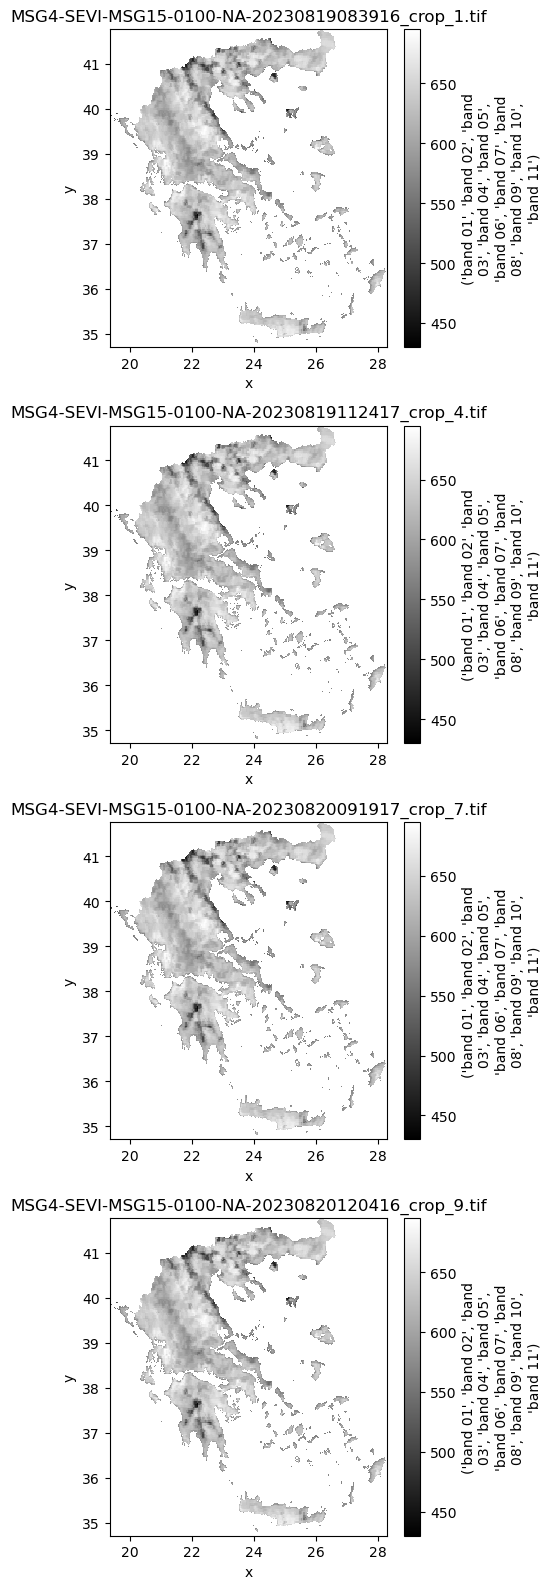

In [10]:
# Δημιουργία ενός πλοτ με όλες τις εικόνες
fig, axes = plt.subplots(len(tif_files), 1, figsize=(5, len(tif_files) * 4))

for idx, tif_file in enumerate(tif_files):
    # Εμφάνιση της εικόνας
    seviri_channel9_inter_masked.seviri_channel9.plot(ax=axes[idx], cmap='gray')
    
    # Προσαρμογή των τίτλων
    axes[idx].set_title(os.path.basename(tif_file))

plt.tight_layout()  # Αυτόματη προσαρμογή της διάταξης
plt.show()

In [38]:
#SEVIRI CLOUD MASK
import os
import glob
import xarray as xr
import numpy as np

# Καθορίστε τον φάκελο που περιέχει τα αρχεία TIFF
image_seviri_cloud_folder = r"C:\Users\valentina\Desktop\Super_Resolution_Alexandroupoli\SEVIRI_CLOUD_MASK"

# Βρείτε όλα τα αρχεία TIFF στον φάκελο
tif_files = glob.glob(os.path.join(image_seviri_cloud_folder, "*.tif"))

result_list_seviricloudmask = []

# Εφαρμόστε τη διαδικασία για κάθε αρχείο TIFF
for tif_file in tif_files:
    
    tif_date = re.split(r'[-\\_]', tif_file)[-3]

    # Ανοίξτε το αρχείο χρησιμοποιώντας την xarray
    seviri_cloud = xr.open_dataset(tif_file)
    
    # Αφαιρέστε τη διάσταση 'band' και τη μεταβλητή 'spatial_ref'
    seviri_cloud = seviri_cloud.squeeze('band').drop(['band','spatial_ref'])
    
    # Μετονομάστε τη μεταβλητή 'band_data' σε 'seviri_cloud'
    seviri_cloud = seviri_cloud.rename({'band_data':'seviri_cloud'})
    
    # Εφαρμογή των ενεργειών για το κάθε seviri_cloud
    standard_image = binary_image
    seviri_channel4_inter = seviri_cloud.interp(x=standard_image["x"], y=standard_image["y"], method='nearest')
    
    # Έλεγχος για την ισότητα των συντεταγμένων
    equal_x = np.array_equal(seviri_channel4_inter.x, standard_image.x)
    equal_y = np.array_equal(seviri_channel4_inter.y, standard_image.y)
    
    # Αντικατάσταση των τιμών όπου το standard_image δεν είναι 0
    seviri_interp_masked = seviri_channel4_inter.where(standard_image.binary_image!=0)
    
    # Επανενσωμάτωση και έλεγχος των συντεταγμένων
    seviri_interp_masked = seviri_interp_masked.interp(y=standard_image["y"], x=standard_image["x"], method='nearest')
    equal_x = np.array_equal(seviri_interp_masked.x, standard_image.x)
    equal_y = np.array_equal(seviri_interp_masked.y, standard_image.y)
    print(equal_x, equal_y)
    
    seviri_interp_masked = seviri_interp_masked.assign_attrs(date=tif_date)
    seviri_interp_masked = seviri_interp_masked.reindex(y=list(reversed(seviri_interp_masked.y)))

    # Εμφάνιση του τελικού αποτελέσματος
    print(seviri_interp_masked)
    
    result_list_seviricloudmask.append(seviri_interp_masked)


True True
<xarray.Dataset>
Dimensions:       (y: 706, x: 896)
Coordinates:
  * y             (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x             (x) float64 19.35 19.36 19.37 19.38 ... 28.27 28.28 28.29 28.3
Data variables:
    seviri_cloud  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    date:     20230819083500
True True
<xarray.Dataset>
Dimensions:       (y: 706, x: 896)
Coordinates:
  * y             (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x             (x) float64 19.35 19.36 19.37 19.38 ... 28.27 28.28 28.29 28.3
Data variables:
    seviri_cloud  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    date:     20230819112000
True True
<xarray.Dataset>
Dimensions:       (y: 706, x: 896)
Coordinates:
  * y             (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x             (x) float64 19.35 19.36 19.37 19.38 ... 28.27 28.28 28.29 28.3
Data variables:
    seviri_c

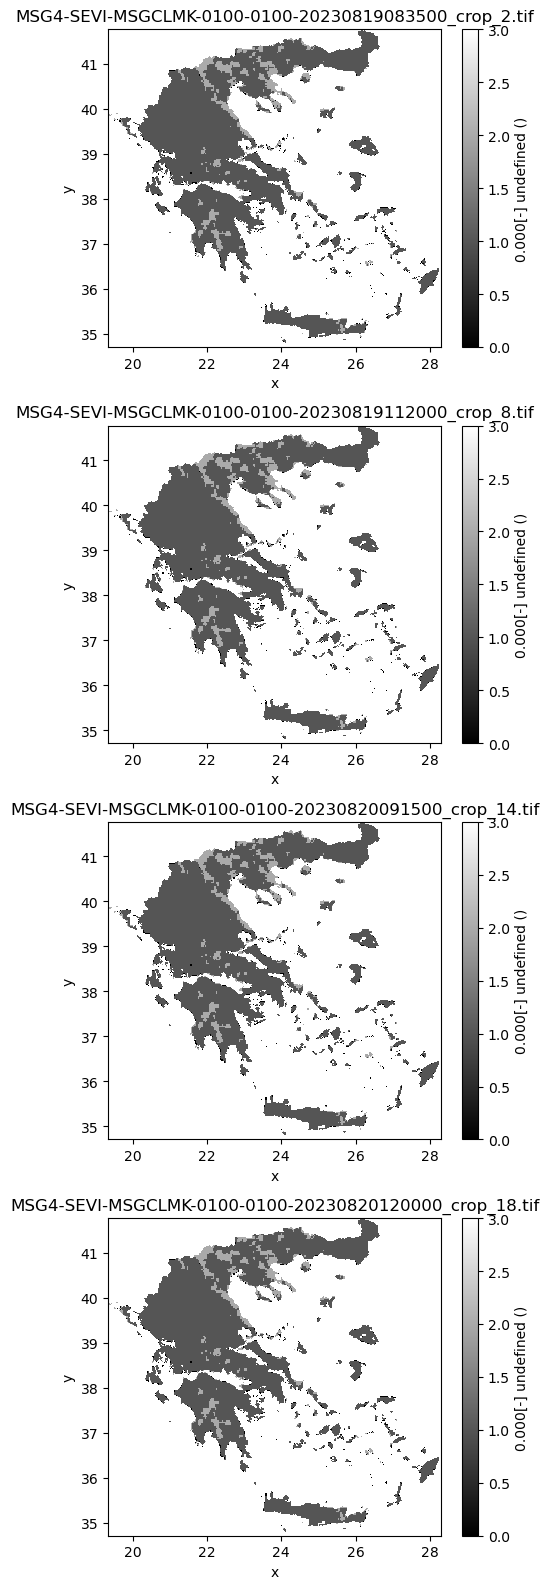

In [12]:
# Δημιουργία ενός πλοτ με όλες τις εικόνες
fig, axes = plt.subplots(len(tif_files), 1, figsize=(5, len(tif_files) * 4))

for idx, tif_file in enumerate(tif_files):
    # Εμφάνιση της εικόνας
    seviri_interp_masked.seviri_cloud.plot(ax=axes[idx], cmap='gray')
    
    # Προσαρμογή των τίτλων
    axes[idx].set_title(os.path.basename(tif_file))

plt.tight_layout()  # Αυτόματη προσαρμογή της διάταξης
plt.show()

In [39]:
#MODIS CHANNEL 21
import os
import glob
import xarray as xr
import numpy as np

# Καθορίστε τον φάκελο που περιέχει τα αρχεία TIFF
image_modis_channel21_folder = r"C:\Users\valentina\Desktop\Super_Resolution_Alexandroupoli\MODIS_IMAGES_CHANNEL_21"

# Βρείτε όλα τα αρχεία TIFF στον φάκελο
tif_files = glob.glob(os.path.join(image_modis_channel21_folder, "*.tif"))

result_list_modischannel21 = []

# Εφαρμόστε τη διαδικασία για κάθε αρχείο TIFF
for tif_file in tif_files:
    
    tif_date = re.split(r'[._\\_]', tif_file)[15]
    
    # Ανοίξτε το αρχείο χρησιμοποιώντας την xarray
    modis_channel21 = xr.open_dataset(tif_file)
    
    # Αφαιρέστε τη διάσταση 'band' και τη μεταβλητή 'spatial_ref'
    modis_channel21 = modis_channel21.squeeze('band').drop(['band','spatial_ref'])
    
    # Μετονομάστε τη μεταβλητή 'band_data' σε 'seviri_cloud'
    modis_channel21 = modis_channel21.rename({'band_data':'modis_channel21'})
    
    # Εφαρμογή των ενεργειών για το κάθε seviri_cloud
    standard_image = binary_image
    modis_channel21_inter = modis_channel21.interp(x=standard_image["x"], y=standard_image["y"], method='nearest')
    
    # Έλεγχος για την ισότητα των συντεταγμένων
    equal_x = np.array_equal(modis_channel21_inter.x, standard_image.x)
    equal_y = np.array_equal(modis_channel21_inter.y, standard_image.y)
    
    # Αντικατάσταση των τιμών όπου το standard_image δεν είναι 0
    modis_channel21_inter_masked = modis_channel21_inter.where(standard_image.binary_image!=0)
    
    # Επανενσωμάτωση και έλεγχος των συντεταγμένων
    modis_channel21_inter_masked = modis_channel21_inter_masked.interp(y=standard_image["y"], x=standard_image["x"], method='nearest')
    equal_x = np.array_equal(modis_channel21_inter_masked.x, standard_image.x)
    equal_y = np.array_equal(modis_channel21_inter_masked.y, standard_image.y)
    print(equal_x, equal_y)
    
    modis_channel21_inter_masked = modis_channel21_inter_masked.assign_attrs(date=tif_date)
    modis_channel21_inter_masked = modis_channel21_inter_masked.reindex(y=list(reversed(modis_channel21_inter_masked.y)))
    
    # Εμφάνιση του τελικού αποτελέσματος
    print(modis_channel21_inter_masked)
    
    result_list_modischannel21.append(modis_channel21_inter_masked)


True True
<xarray.Dataset>
Dimensions:          (y: 706, x: 896)
Coordinates:
  * y                (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x                (x) float64 19.35 19.36 19.37 19.38 ... 28.28 28.29 28.3
Data variables:
    modis_channel21  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    date:     0835
True True
<xarray.Dataset>
Dimensions:          (y: 706, x: 896)
Coordinates:
  * y                (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x                (x) float64 19.35 19.36 19.37 19.38 ... 28.28 28.29 28.3
Data variables:
    modis_channel21  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    date:     0915
True True
<xarray.Dataset>
Dimensions:          (y: 706, x: 896)
Coordinates:
  * y                (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x                (x) float64 19.35 19.36 19.37 19.38 ... 28.28 28.29 28.3
Data variables:
    modis_channel21  (y, 

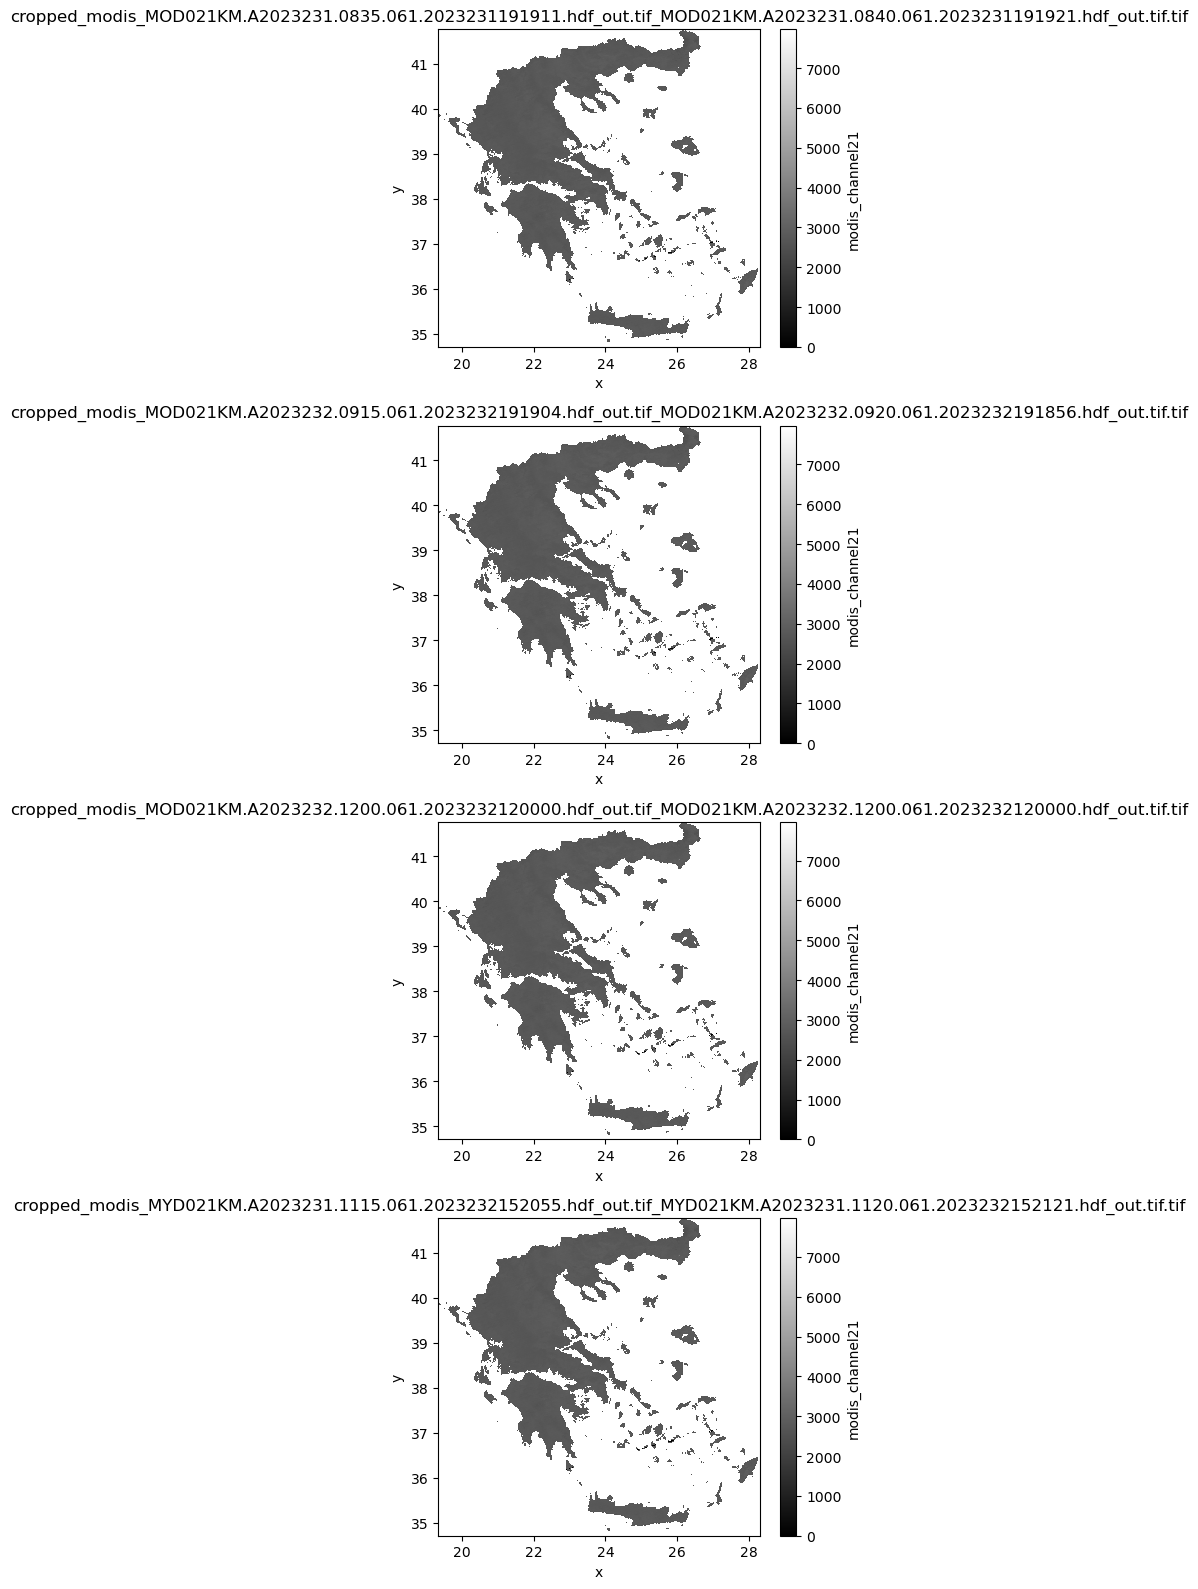

In [14]:
# Δημιουργία ενός πλοτ με όλες τις εικόνες
fig, axes = plt.subplots(len(tif_files), 1, figsize=(5, len(tif_files) * 4))

for idx, tif_file in enumerate(tif_files):
    # Εμφάνιση της εικόνας
    modis_channel21_inter_masked.modis_channel21.plot(ax=axes[idx], cmap='gray')
    
    # Προσαρμογή των τίτλων
    axes[idx].set_title(os.path.basename(tif_file))

plt.tight_layout()  # Αυτόματη προσαρμογή της διάταξης
plt.show()

In [40]:
#MODIS CHANNEL 22
import os
import glob
import xarray as xr
import numpy as np

# Καθορίστε τον φάκελο που περιέχει τα αρχεία TIFF
image_modis_channel22_folder = r"C:\Users\valentina\Desktop\Super_Resolution_Alexandroupoli\MODIS_IMAGES_CHANNEL_22"

# Βρείτε όλα τα αρχεία TIFF στον φάκελο
tif_files = glob.glob(os.path.join(image_modis_channel22_folder, "*.tif"))

result_list_modischannel22 = []

# Εφαρμόστε τη διαδικασία για κάθε αρχείο TIFF
for tif_file in tif_files:
    
    tif_date = re.split(r'[._\\_]', tif_file)[15]
    
    # Ανοίξτε το αρχείο χρησιμοποιώντας την xarray
    modis_channel22 = xr.open_dataset(tif_file)
    
    # Αφαιρέστε τη διάσταση 'band' και τη μεταβλητή 'spatial_ref'
    modis_channel22 = modis_channel22.squeeze('band').drop(['band','spatial_ref'])
    
    # Μετονομάστε τη μεταβλητή 'band_data' σε 'seviri_cloud'
    modis_channel22 = modis_channel22.rename({'band_data':'modis_channel22'})
    
    # Εφαρμογή των ενεργειών για το κάθε seviri_cloud
    standard_image = binary_image
    modis_channel22_inter = modis_channel22.interp(x=standard_image["x"], y=standard_image["y"], method='nearest')
    
    # Έλεγχος για την ισότητα των συντεταγμένων
    equal_x = np.array_equal(modis_channel22_inter.x, standard_image.x)
    equal_y = np.array_equal(modis_channel22_inter.y, standard_image.y)
    
    # Αντικατάσταση των τιμών όπου το standard_image δεν είναι 0
    modis_channel22_inter_masked = modis_channel22_inter.where(standard_image.binary_image!=0)
    
    # Επανενσωμάτωση και έλεγχος των συντεταγμένων
    modis_channel22_inter_masked = modis_channel22_inter_masked.interp(y=standard_image["y"], x=standard_image["x"], method='nearest')
    equal_x = np.array_equal(modis_channel22_inter_masked.x, standard_image.x)
    equal_y = np.array_equal(modis_channel22_inter_masked.y, standard_image.y)
    print(equal_x, equal_y)
    
    modis_channel22_inter_masked = modis_channel22_inter_masked.assign_attrs(date=tif_date)
    modis_channel22_inter_masked = modis_channel22_inter_masked.reindex(y=list(reversed(modis_channel22_inter_masked.y)))
    
    # Εμφάνιση του τελικού αποτελέσματος
    print(modis_channel22_inter_masked)
    
    result_list_modischannel22.append(modis_channel22_inter_masked)


True True
<xarray.Dataset>
Dimensions:          (y: 706, x: 896)
Coordinates:
  * y                (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x                (x) float64 19.35 19.36 19.37 19.38 ... 28.28 28.29 28.3
Data variables:
    modis_channel22  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    date:     0835
True True
<xarray.Dataset>
Dimensions:          (y: 706, x: 896)
Coordinates:
  * y                (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x                (x) float64 19.35 19.36 19.37 19.38 ... 28.28 28.29 28.3
Data variables:
    modis_channel22  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    date:     0915
True True
<xarray.Dataset>
Dimensions:          (y: 706, x: 896)
Coordinates:
  * y                (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x                (x) float64 19.35 19.36 19.37 19.38 ... 28.28 28.29 28.3
Data variables:
    modis_channel22  (y, 

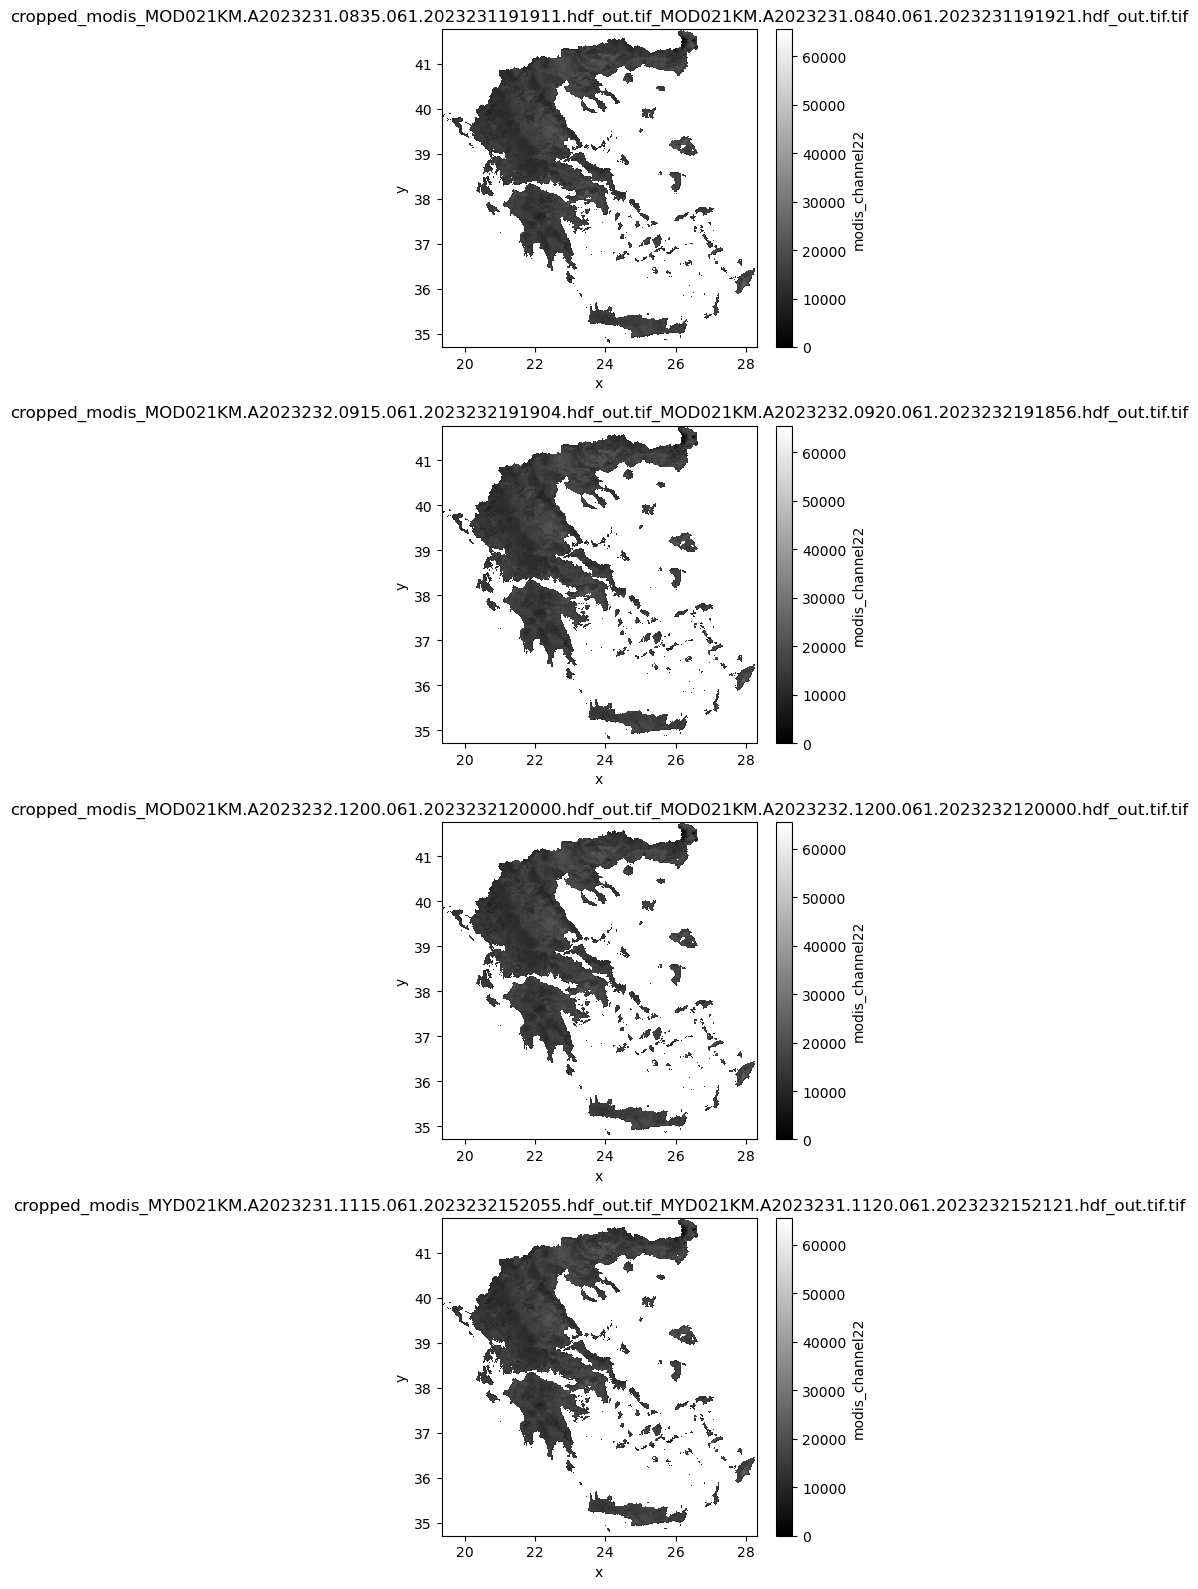

In [34]:
# Δημιουργία ενός πλοτ με όλες τις εικόνες
fig, axes = plt.subplots(len(tif_files), 1, figsize=(5, len(tif_files) * 4))

for idx, tif_file in enumerate(tif_files):
    # Εμφάνιση της εικόνας
    modis_channel22_inter_masked.modis_channel22.plot(ax=axes[idx], cmap='gray')
    
    # Προσαρμογή των τίτλων
    axes[idx].set_title(os.path.basename(tif_file))

plt.tight_layout()  # Αυτόματη προσαρμογή της διάταξης
plt.show()

In [41]:
#MODIS CHANNEL 31
import os
import glob
import xarray as xr
import numpy as np

# Καθορίστε τον φάκελο που περιέχει τα αρχεία TIFF
image_modis_channel31_folder = r"C:\Users\valentina\Desktop\Super_Resolution_Alexandroupoli\MODIS_IMAGES_CHANNEL_31"

# Βρείτε όλα τα αρχεία TIFF στον φάκελο
tif_files = glob.glob(os.path.join(image_modis_channel31_folder, "*.tif"))

result_list_modischannel31 = []

# Εφαρμόστε τη διαδικασία για κάθε αρχείο TIFF
for tif_file in tif_files:
    
    tif_date = re.split(r'[._\\_]', tif_file)[15]
    
    # Ανοίξτε το αρχείο χρησιμοποιώντας την xarray
    modis_channel31 = xr.open_dataset(tif_file)
    
    # Αφαιρέστε τη διάσταση 'band' και τη μεταβλητή 'spatial_ref'
    modis_channel31 = modis_channel31.squeeze('band').drop(['band','spatial_ref'])
    
    # Μετονομάστε τη μεταβλητή 'band_data' σε 'seviri_cloud'
    modis_channel31 = modis_channel31.rename({'band_data':'modis_channel31'})
    
    # Εφαρμογή των ενεργειών για το κάθε seviri_cloud
    standard_image = binary_image
    modis_channel31_inter = modis_channel31.interp(x=standard_image["x"], y=standard_image["y"], method='nearest')
    
    # Έλεγχος για την ισότητα των συντεταγμένων
    equal_x = np.array_equal(modis_channel31_inter.x, standard_image.x)
    equal_y = np.array_equal(modis_channel31_inter.y, standard_image.y)
    
    # Αντικατάσταση των τιμών όπου το standard_image δεν είναι 0
    modis_channel31_inter_masked = modis_channel31_inter.where(standard_image.binary_image!=0)
    
    # Επανενσωμάτωση και έλεγχος των συντεταγμένων
    modis_channel31_inter_masked = modis_channel31_inter_masked.interp(y=standard_image["y"], x=standard_image["x"], method='nearest')
    equal_x = np.array_equal(modis_channel31_inter_masked.x, standard_image.x)
    equal_y = np.array_equal(modis_channel31_inter_masked.y, standard_image.y)
    print(equal_x, equal_y)
    
    modis_channel31_inter_masked = modis_channel31_inter_masked.assign_attrs(date=tif_date)
    modis_channel31_inter_masked = modis_channel31_inter_masked.reindex(y=list(reversed(modis_channel31_inter_masked.y)))
   
    # Εμφάνιση του τελικού αποτελέσματος
    print(modis_channel31_inter_masked)
    
    result_list_modischannel31.append(modis_channel31_inter_masked)


True True
<xarray.Dataset>
Dimensions:          (y: 706, x: 896)
Coordinates:
  * y                (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x                (x) float64 19.35 19.36 19.37 19.38 ... 28.28 28.29 28.3
Data variables:
    modis_channel31  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    date:     0835
True True
<xarray.Dataset>
Dimensions:          (y: 706, x: 896)
Coordinates:
  * y                (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x                (x) float64 19.35 19.36 19.37 19.38 ... 28.28 28.29 28.3
Data variables:
    modis_channel31  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    date:     0915
True True
<xarray.Dataset>
Dimensions:          (y: 706, x: 896)
Coordinates:
  * y                (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x                (x) float64 19.35 19.36 19.37 19.38 ... 28.28 28.29 28.3
Data variables:
    modis_channel31  (y, 

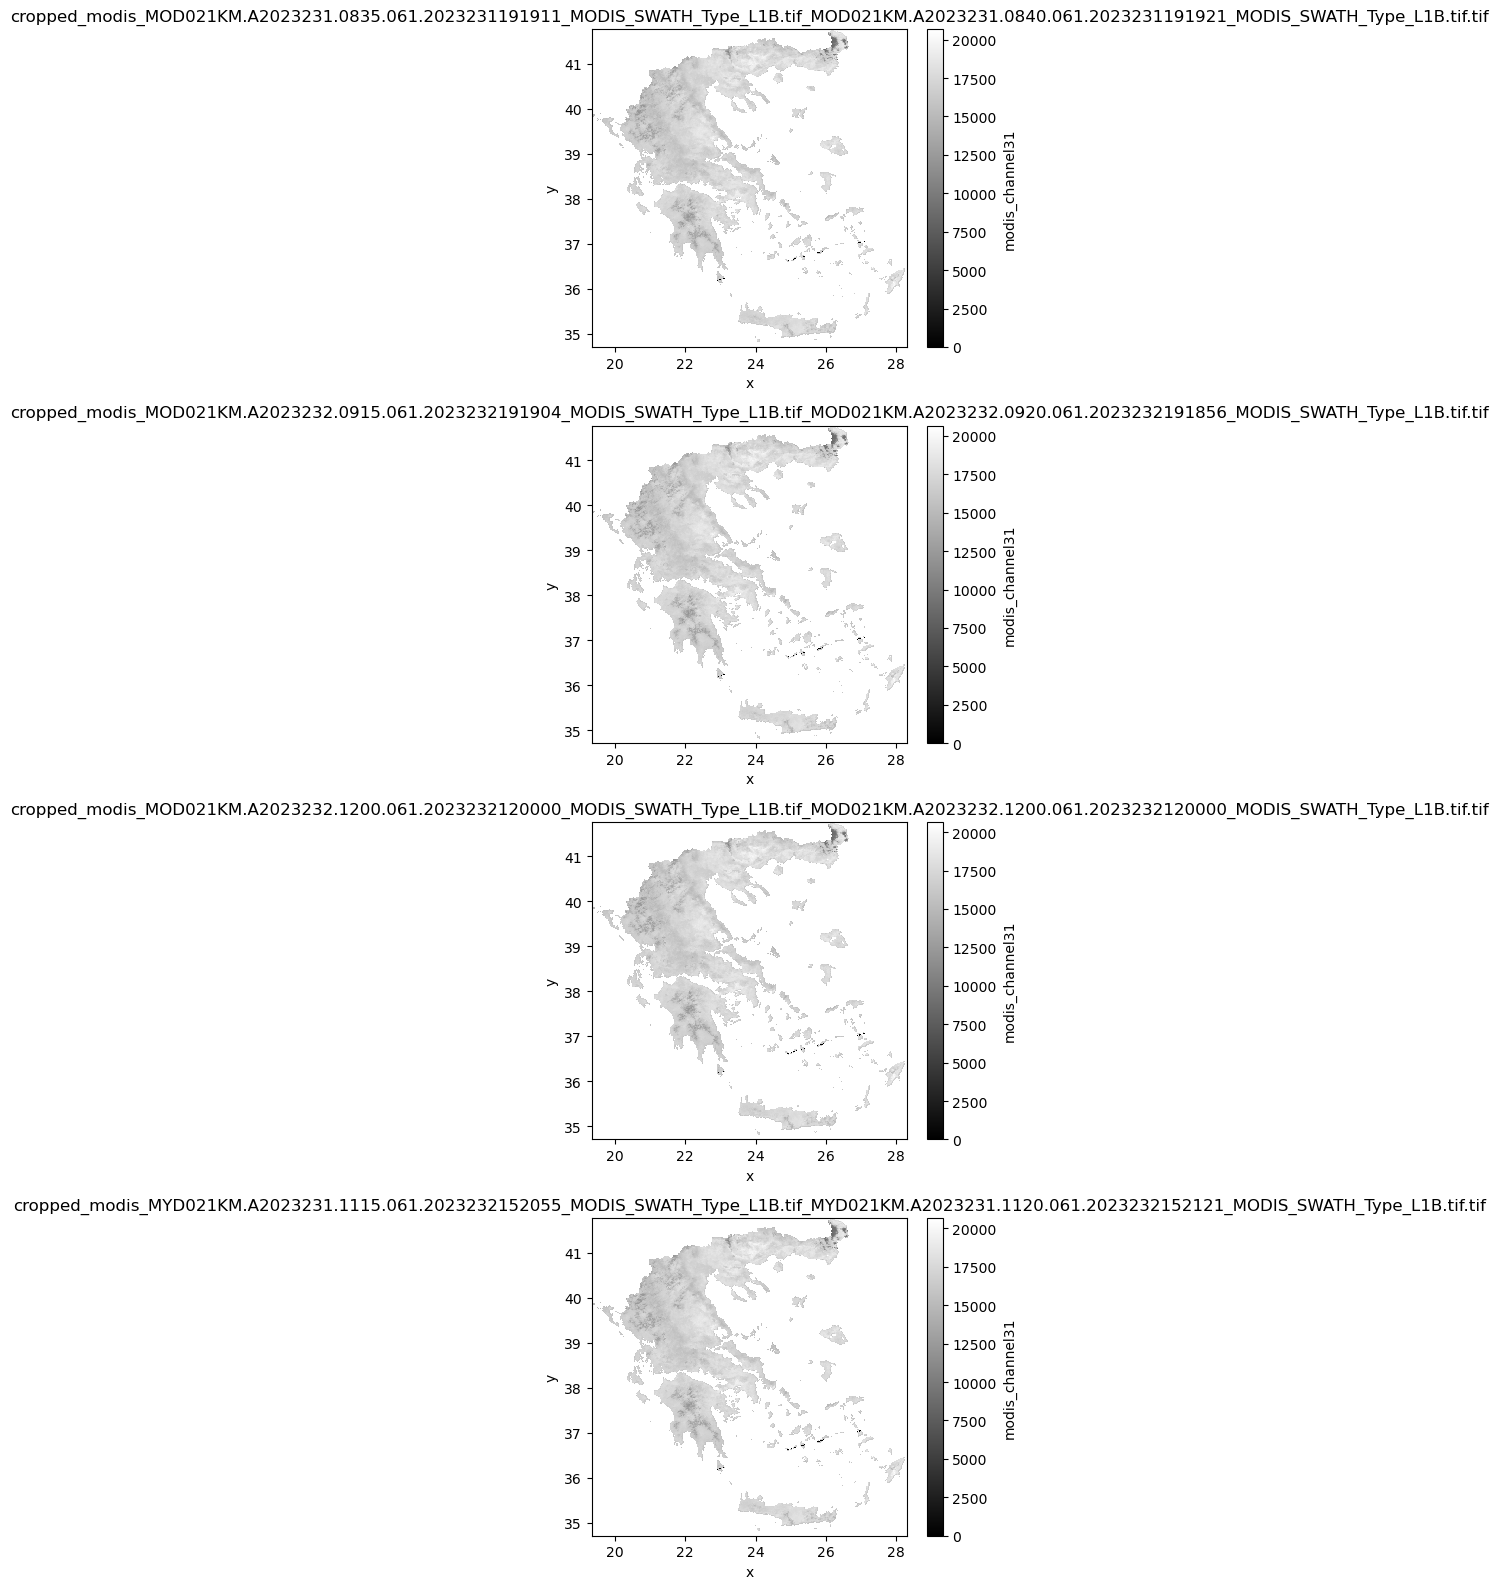

In [31]:
# Δημιουργία ενός πλοτ με όλες τις εικόνες
fig, axes = plt.subplots(len(tif_files), 1, figsize=(5, len(tif_files) * 4))

for idx, tif_file in enumerate(tif_files):
    # Εμφάνιση της εικόνας
    modis_channel31_inter_masked.modis_channel31.plot(ax=axes[idx], cmap='gray')
    
    # Προσαρμογή των τίτλων
    axes[idx].set_title(os.path.basename(tif_file))

plt.tight_layout()  # Αυτόματη προσαρμογή της διάταξης
plt.show()

In [42]:
#MODIS CLOUD MASK
import os
import glob
import xarray as xr
import numpy as np

# Καθορίστε τον φάκελο που περιέχει τα αρχεία TIFF
image_modis_cloud_mask_folder = r"C:\Users\valentina\Desktop\Super_Resolution_Alexandroupoli\MODIS_CLOUD_MASK"

# Βρείτε όλα τα αρχεία TIFF στον φάκελο
tif_files = glob.glob(os.path.join(image_modis_cloud_mask_folder, "*.tif"))

result_modiscloudmasks = []

# Εφαρμόστε τη διαδικασία για κάθε αρχείο TIFF
for tif_file in tif_files:
    
    tif_date = re.split(r'[._\\_]', tif_file)[15]
        
    # Ανοίξτε το αρχείο χρησιμοποιώντας την xarray
    modis_cloud_mask = xr.open_dataset(tif_file)
    
    # Αφαιρέστε τη διάσταση 'band' και τη μεταβλητή 'spatial_ref'
    modis_cloud_mask = modis_cloud_mask.squeeze('band').drop(['band','spatial_ref'])
    
    # Μετονομάστε τη μεταβλητή 'band_data' σε 'seviri_cloud'
    modis_cloud_mask = modis_cloud_mask.rename({'band_data':'modis_cloud_mask'})
    
    # Εφαρμογή των ενεργειών για το κάθε seviri_cloud
    standard_image = binary_image
    modis_cloud_mask_inter = modis_cloud_mask.interp(x=standard_image["x"], y=standard_image["y"], method='nearest')
    
    # Έλεγχος για την ισότητα των συντεταγμένων
    equal_x = np.array_equal(modis_cloud_mask_inter.x, standard_image.x)
    equal_y = np.array_equal(modis_cloud_mask_inter.y, standard_image.y)
    
    # Αντικατάσταση των τιμών όπου το standard_image δεν είναι 0
    modis_cloud_mask_inter_masked = modis_cloud_mask_inter.where(standard_image.binary_image!=0)
    
    # Επανενσωμάτωση και έλεγχος των συντεταγμένων
    modis_cloud_mask_inter_masked = modis_cloud_mask_inter_masked.interp(y=standard_image["y"], x=standard_image["x"], method='nearest')
    equal_x = np.array_equal(modis_cloud_mask_inter_masked.x, standard_image.x)
    equal_y = np.array_equal(modis_cloud_mask_inter_masked.y, standard_image.y)
    print(equal_x, equal_y)
    
    modis_cloud_mask_inter_masked = modis_cloud_mask_inter_masked.assign_attrs(date=tif_date)
    modis_cloud_mask_inter_masked = modis_cloud_mask_inter_masked.reindex(y=list(reversed(modis_cloud_mask_inter_masked.y)))

    # Εμφάνιση του τελικού αποτελέσματος
    print(modis_cloud_mask_inter_masked)
    
    result_modiscloudmasks.append(modis_cloud_mask_inter_masked)

True True
<xarray.Dataset>
Dimensions:           (y: 706, x: 896)
Coordinates:
  * y                 (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x                 (x) float64 19.35 19.36 19.37 19.38 ... 28.28 28.29 28.3
Data variables:
    modis_cloud_mask  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    date:     0835
True True
<xarray.Dataset>
Dimensions:           (y: 706, x: 896)
Coordinates:
  * y                 (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x                 (x) float64 19.35 19.36 19.37 19.38 ... 28.28 28.29 28.3
Data variables:
    modis_cloud_mask  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    date:     0915
True True
<xarray.Dataset>
Dimensions:           (y: 706, x: 896)
Coordinates:
  * y                 (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x                 (x) float64 19.35 19.36 19.37 19.38 ... 28.28 28.29 28.3
Data variables:
    modis_clou

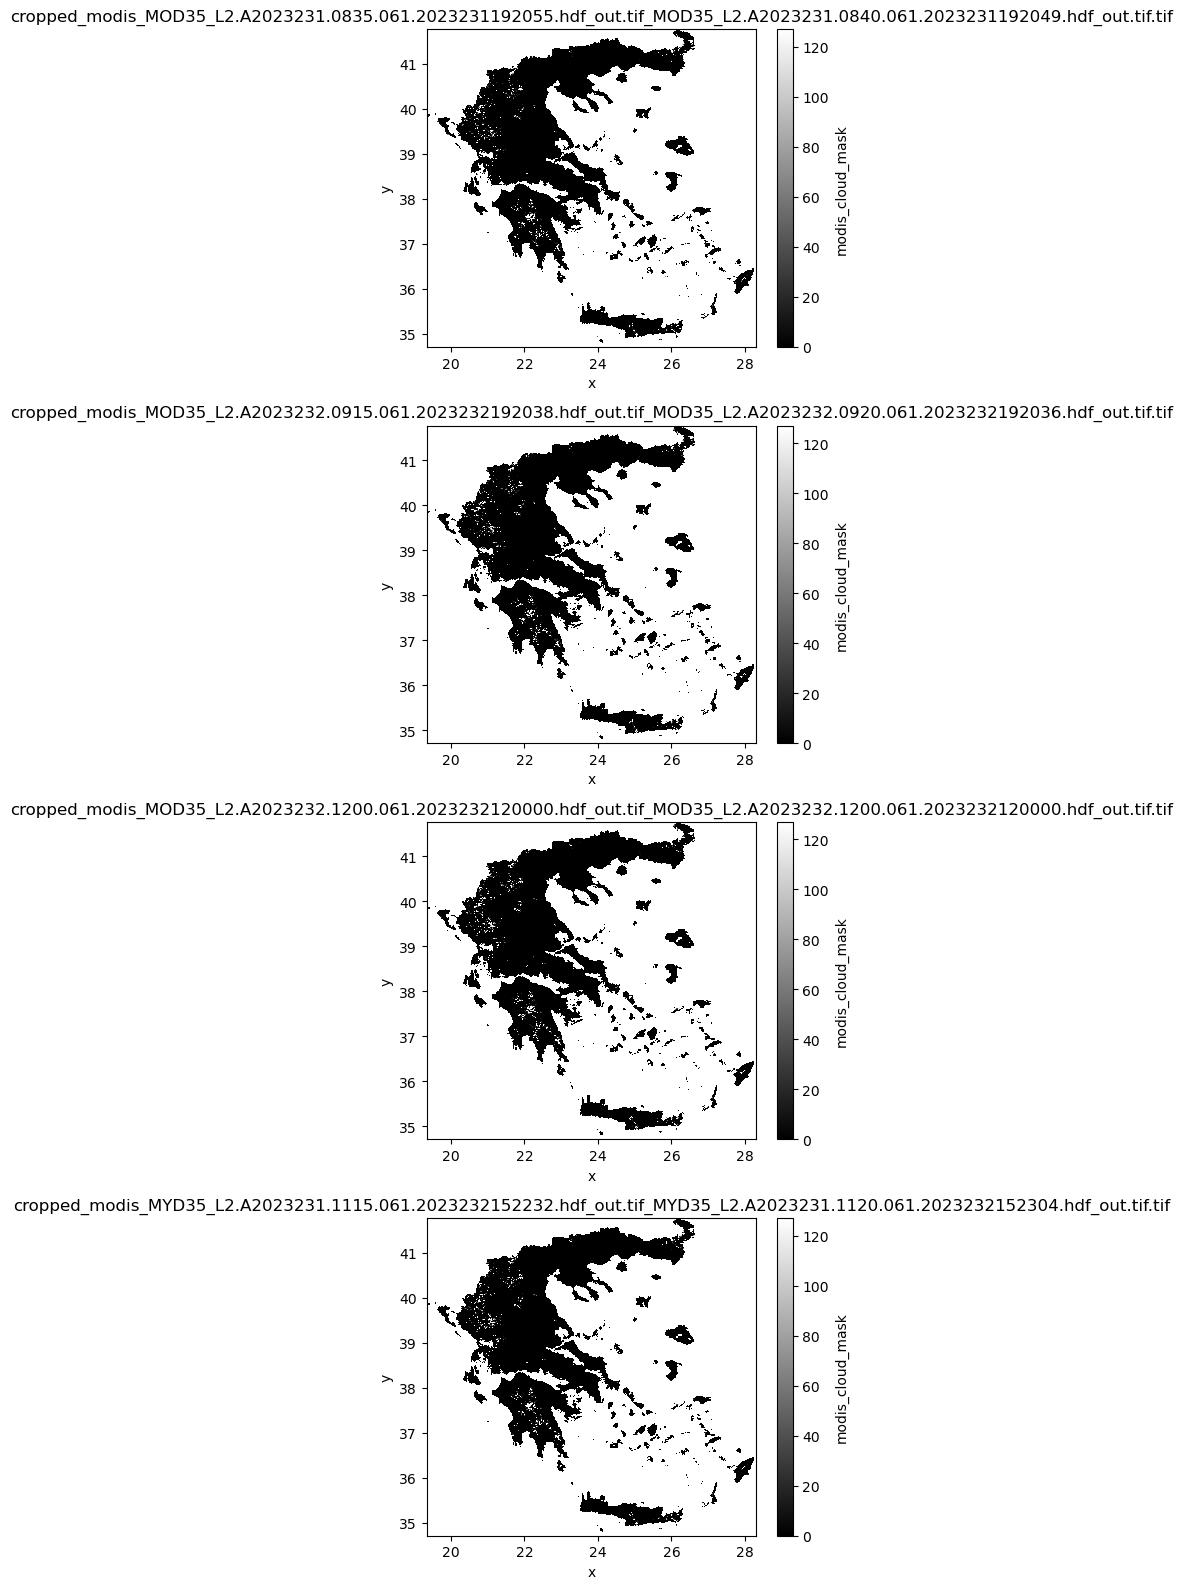

In [27]:
# Δημιουργία ενός πλοτ με όλες τις εικόνες
fig, axes = plt.subplots(len(tif_files), 1, figsize=(5, len(tif_files) * 4))

for idx, tif_file in enumerate(tif_files):
    # Εμφάνιση της εικόνας
    modis_cloud_mask_inter_masked.modis_cloud_mask.plot(ax=axes[idx], cmap='gray')
    
    # Προσαρμογή των τίτλων
    axes[idx].set_title(os.path.basename(tif_file))

plt.tight_layout()  # Αυτόματη προσαρμογή της διάταξης
plt.show()

In [43]:
#DEM
file_dem = r"C:\Users\valentina\Desktop\Super_Resolution_Alexandroupoli\Layers\dem_greece.tif"
dem = xr.open_dataset(file_dem)
dem = dem.squeeze('band')
#Delete coordinates band and spatial_ref
dem = dem.drop(['band','spatial_ref'])
#Rename Data variable to ndvi
dem = dem.rename({'band_data':'dem'})

standard_image = binary_image
dem_interp = dem.interp(x=standard_image["x"],y=standard_image["y"],method='nearest')
np.array_equal(dem_interp.y, standard_image.y)
np.array_equal(dem_interp.x, standard_image.x)
dem_interp_masked = dem_interp.where(standard_image.binary_image!=0)
dem_interp_masked = dem_interp_masked.interp(y=standard_image["y"], x=standard_image["x"],method='nearest')
np.array_equal(dem_interp_masked.y, standard_image.y)
np.array_equal(dem_interp_masked.x, standard_image.x)
dem_interp_masked

<xarray.Dataset>
Dimensions:  (y: 706, x: 896)
Coordinates:
  * y        (y) float64 41.76 41.75 41.74 41.73 ... 34.74 34.73 34.72 34.71
  * x        (x) float64 19.35 19.36 19.37 19.38 ... 28.27 28.28 28.29 28.3
Data variables:
    dem      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan

In [44]:
dem_interp_masked = dem_interp_masked.reindex(y=list(reversed(dem_interp_masked.y)))

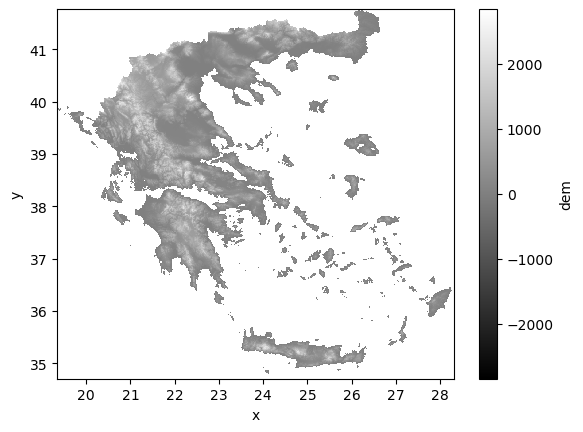

In [19]:
dem_interp_masked.dem.plot(cmap='gray')

In [45]:
#ASPECT
file_aspect = r"C:\Users\valentina\Desktop\Super_Resolution_Alexandroupoli\Layers\aspect_greece.tif"
aspect = xr.open_dataset(file_aspect)
aspect = aspect.squeeze('band')
#Delete coordinates band and spatial_ref
aspect = aspect.drop(['band','spatial_ref'])
#Rename Data variable to ndvi
aspect = aspect.rename({'band_data':'aspect'})

standard_image = binary_image
aspect_interp = aspect.interp(x=standard_image["x"],y=standard_image["y"],method='nearest')
np.array_equal(aspect_interp.x, standard_image.x)
np.array_equal(aspect_interp.y, standard_image.y)
aspect_interp_masked = aspect_interp.where(standard_image.binary_image!=0)
aspect_interp_masked = aspect_interp_masked.interp(y=standard_image["y"], x=standard_image["x"],method='nearest')
np.array_equal(aspect_interp_masked.x, standard_image.x)
np.array_equal(aspect_interp_masked.y, standard_image.y)
aspect_interp_masked

<xarray.Dataset>
Dimensions:  (y: 706, x: 896)
Coordinates:
  * y        (y) float64 41.76 41.75 41.74 41.73 ... 34.74 34.73 34.72 34.71
  * x        (x) float64 19.35 19.36 19.37 19.38 ... 28.27 28.28 28.29 28.3
Data variables:
    aspect   (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan

In [46]:
aspect_interp_masked = aspect_interp_masked.reindex(y=list(reversed(aspect_interp_masked.y)))

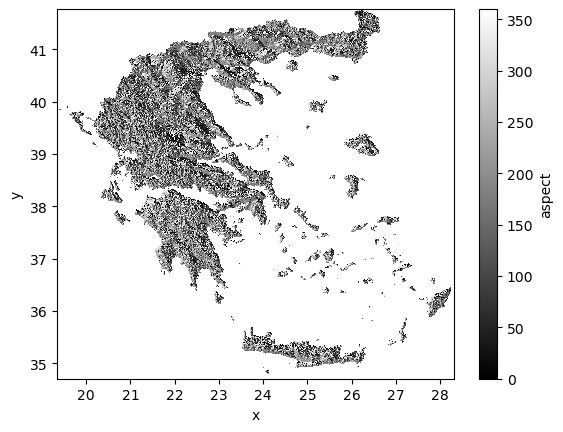

In [9]:
aspect_interp_masked.aspect.plot(cmap='gray')

In [10]:
aspect_interp_masked.rio.to_raster(f'test4605.nc')

In [47]:
#SLOPE
file_slope = r"C:\Users\valentina\Desktop\Super_Resolution_Alexandroupoli\Layers\slope_greece.tif"
slope = xr.open_dataset(file_slope)
slope = slope.squeeze('band')
#Delete coordinates band and spatial_ref
slope = slope.drop(['band','spatial_ref'])
#Rename Data variable to ndvi
slope = slope.rename({'band_data':'slope'})

standard_image = binary_image
slope_interp = slope.interp(x=standard_image["x"],y=standard_image["y"],method='nearest')
np.array_equal(slope_interp.x, standard_image.x)
np.array_equal(slope_interp.y, standard_image.y)
slope_interp_masked = slope_interp.where(standard_image.binary_image!=0)
slope_interp_masked = slope_interp_masked.interp(y=standard_image["y"], x=standard_image["x"],method='nearest')
np.array_equal(slope_interp_masked.x, standard_image.x)
np.array_equal(slope_interp_masked.y, standard_image.y)
slope_interp_masked

<xarray.Dataset>
Dimensions:  (y: 706, x: 896)
Coordinates:
  * y        (y) float64 41.76 41.75 41.74 41.73 ... 34.74 34.73 34.72 34.71
  * x        (x) float64 19.35 19.36 19.37 19.38 ... 28.27 28.28 28.29 28.3
Data variables:
    slope    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan

In [48]:
slope_interp_masked = slope_interp_masked.reindex(y=list(reversed(slope_interp_masked.y)))

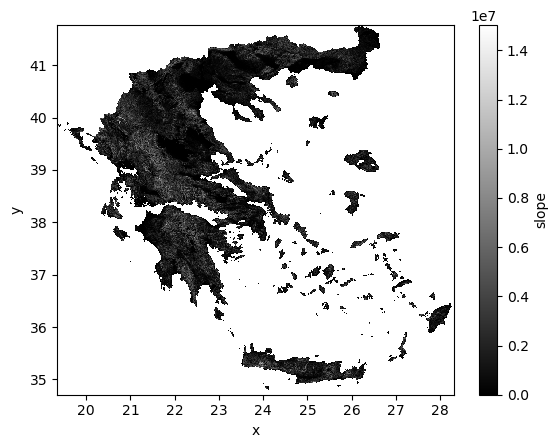

In [25]:
slope_interp_masked.slope.plot(cmap='gray')

In [49]:
#FUEL
file_fuel = r"C:\Users\valentina\Desktop\Super_Resolution_Alexandroupoli\Layers\fuel_greece.tif"
fuel = xr.open_dataset(file_fuel)
fuel = fuel.squeeze('band')
#Delete coordinates band and spatial_ref
fuel = fuel.drop(['band','spatial_ref'])
#Rename Data variable to ndvi
fuel = fuel.rename({'band_data':'fuel'})

standard_image = binary_image
fuel_interp = fuel.interp(x=standard_image["x"],y=standard_image["y"],method='nearest')
np.array_equal(fuel_interp.x, standard_image.x), np.array_equal(fuel_interp.y, standard_image.y)
fuel_interp_masked =fuel_interp.where(standard_image.binary_image!=0)
np.array_equal(fuel_interp_masked.x, standard_image.x), np.array_equal(dem_interp_masked.y, standard_image.y)
fuel_interp_masked = fuel_interp_masked.interp(y=standard_image["y"], x=standard_image["x"],method='nearest')
np.array_equal(fuel_interp_masked.x, standard_image.x)
np.array_equal(fuel_interp_masked.y, standard_image.y)
fuel_interp_masked

<xarray.Dataset>
Dimensions:  (y: 706, x: 896)
Coordinates:
  * y        (y) float64 41.76 41.75 41.74 41.73 ... 34.74 34.73 34.72 34.71
  * x        (x) float64 19.35 19.36 19.37 19.38 ... 28.27 28.28 28.29 28.3
Data variables:
    fuel     (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan

In [50]:
fuel_interp_masked = fuel_interp_masked.reindex(y=list(reversed(fuel_interp_masked.y)))

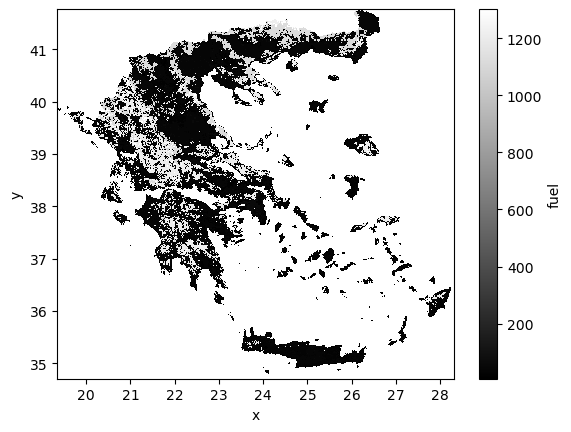

In [28]:
fuel_interp_masked.fuel.plot(cmap='gray')

In [113]:
#FINAL IMAGE
final_images = []
dic_images={0:0,1:3,2:1,3:2}
for key in dic_images.keys():
    value=dic_images[key]
    print(result_list_sevirichannel4[key].date,result_list_modischannel21[value].date)
    final_images.append(xr.merge([result_list_sevirichannelHRV[key],result_list_sevirichannel4[key],result_list_sevirichannel9[key],result_list_seviricloudmask[key],result_list_modischannel21[value],result_list_modischannel22[value],result_list_modischannel31[value],result_modiscloudmasks[value],dem_interp_masked,aspect_interp_masked,slope_interp_masked,fuel_interp_masked]))

0839 0835
1124 1115
0919 0915
1204 1200


In [114]:
final_images[0]

<xarray.Dataset>
Dimensions:           (y: 706, x: 896)
Coordinates:
  * y                 (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x                 (x) float64 19.35 19.36 19.37 19.38 ... 28.28 28.29 28.3
    crs               object GEOGCRS["unknown",DATUM["World Geodetic System 1...
Data variables:
    seviri_HRV        (y, x) float32 dask.array<chunksize=(706, 896), meta=np.ndarray>
    seviri_channel4   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    seviri_channel9   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    seviri_cloud      (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    modis_channel21   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    modis_channel22   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    modis_channel31   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    modis_cloud_mask  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    dem               (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    aspect            (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    slope             (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    fuel              (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/21)
    orbital_parameters:                     {'projection_longitude': 9.5, 'pr...
    sun_earth_distance_correction_applied:  True
    sun_earth_distance_correction_factor:   1.0120745002905316
    units:                                  %
    wavelength:                             0.7 µm (0.5-0.9 µm)
    standard_name:                          toa_bidirectional_reflectance
    ...                                     ...
    resolution:                             1000.134348869
    calibration:                            reflectance
    modifiers:                              ()
    _satpy_id:                              DataID(name='HRV', wavelength=Wav...
    ancillary_variables:                    []
    date:                                   0839

In [64]:
import rasterio as rio
import rioxarray
import os

# Διαβάζει το CRS από το αρχείο εικόνας κλίσης
with rio.open(file_slope) as src:
    slope_crs = src.crs.to_string()

# Εφαρμογή του CRS στα datasets
final_images_crs_applied = []
for image in final_images:
    image_crs_applied = image.rio.write_crs(slope_crs)
    final_images_crs_applied.append(image_crs_applied)

# Διόρθωση των εικόνων
for i, final_image in enumerate(final_images_crs_applied):
    print(i)
    variables = list(final_image.data_vars)
    for var in variables:
        for att in list(final_image[var].attrs.keys()):
            del final_image[var].attrs[att]
    final_image.rio.set_crs(slope_crs)
    final_image.rio.to_raster(f'test{i}.nc')


0
1
2
3


In [79]:
final_image

<xarray.Dataset>
Dimensions:           (y: 706, x: 896)
Coordinates:
  * y                 (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x                 (x) float64 19.35 19.36 19.37 19.38 ... 28.28 28.29 28.3
    crs               object GEOGCRS["unknown",DATUM["World Geodetic System 1...
    spatial_ref       int32 0
Data variables:
    seviri_HRV        (y, x) float32 dask.array<chunksize=(706, 896), meta=np.ndarray>
    seviri_channel4   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    seviri_channel9   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    seviri_cloud      (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    modis_channel21   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    modis_channel22   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    modis_channel31   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    modis_cloud_mask  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    dem               (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    aspect            (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    slope             (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    fuel              (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/21)
    orbital_parameters:                     {'projection_longitude': 9.5, 'pr...
    sun_earth_distance_correction_applied:  True
    sun_earth_distance_correction_factor:   1.0120745002905316
    units:                                  %
    wavelength:                             0.7 µm (0.5-0.9 µm)
    standard_name:                          toa_bidirectional_reflectance
    ...                                     ...
    resolution:                             1000.134348869
    calibration:                            reflectance
    modifiers:                              ()
    _satpy_id:                              DataID(name='HRV', wavelength=Wav...
    ancillary_variables:                    []
    date:                                   0839

In [90]:
import xarray as xr

# Διάβασμα του αρχείου NetCDF
file_path = "C:\\Users\\valentina\\Desktop\\Super_Resolution_Alexandroupoli\\test0.nc"
ds = xr.open_dataset(file_path)
ds

<xarray.Dataset>
Dimensions:  (lat: 706, lon: 896)
Coordinates:
  * lat      (lat) float64 41.76 41.75 41.74 41.73 ... 34.74 34.73 34.72 34.71
  * lon      (lon) float64 19.35 19.36 19.37 19.38 ... 28.27 28.28 28.29 28.3
Data variables: (12/13)
    Band1    (lat, lon) float64 ...
    Band2    (lat, lon) float64 ...
    Band3    (lat, lon) float64 ...
    Band4    (lat, lon) float64 ...
    Band5    (lat, lon) float64 ...
    Band6    (lat, lon) float64 ...
    ...       ...
    Band8    (lat, lon) float64 ...
    Band9    (lat, lon) float64 ...
    Band10   (lat, lon) float64 ...
    Band11   (lat, lon) float64 ...
    Band12   (lat, lon) float64 ...
    crs      |S1 ...
Attributes: (12/24)
    Conventions:                                 CF-1.5
    GDAL:                                        GDAL 3.6.4, released 2023/04/17
    history:                                     Tue Apr 30 13:53:07 2024: GD...
    GDAL_orbital_parameters:                     {'projection_longitude': 9.5...
    GDAL_sun_earth_distance_correction_applied:  True
    GDAL_sun_earth_distance_correction_factor:   1.0120745002905316
    ...                                          ...
    GDAL_resolution:                             1000.134348869
    GDAL_calibration:                            reflectance
    GDAL_modifiers:                              ()
    GDAL__satpy_id:                              DataID(name='HRV', wavelengt...
    GDAL_ancillary_variables:                    []
    GDAL_date:                                   839.0

In [106]:
import rasterio as rio
import rioxarray
import os

# Διαβάζει το CRS από το αρχείο εικόνας κλίσης
with rio.open(file_slope) as src:
    slope_crs = src.crs.to_string()

# Εφαρμογή του CRS στα datasets
final_images_crs_applied = []
for image in final_images:
    image_crs_applied = image.rio.write_crs(slope_crs)
    final_images_crs_applied.append(image_crs_applied)

# Διόρθωση των εικόνων
for i, final_image in enumerate(final_images_crs_applied):
    print(i)
    variables = list(final_image.data_vars)
    for var in variables:
        for att in list(final_image[var].attrs.keys()):
            del final_image[var].attrs[att]
    final_image.rio.set_crs(slope_crs)

    final_image_renamed = final_image.rename({var: var for var in final_image.data_vars})  # Μετονομασία μεταβλητών
    # Εγγραφή του αρχείου NetCDF με το σωστό format
    final_image_renamed = final_image.rename({var: var for var in final_image.data_vars})  # Μετονομασία μεταβλητών
    final_image_renamed.attrs.pop('orbital_parameters', None)  # Αφαίρεση του προβληματικού attribute
    final_image_renamed.attrs.pop('georef_offset_corrected', None)  # Αφαίρεση του προβληματικού attribute
    final_image_renamed.attrs.pop('time_parameters', None)  # Αφαίρεση του προβληματικού attribute
    final_image_renamed.attrs.pop('start_time', None)  # Αφαίρεση του προβληματικού attribute
    final_image_renamed.attrs.pop('end_time', None)  # Αφαίρεση του προβληματικού attribute
    final_image_renamed.attrs.pop('area', None)  # Αφαίρεση του προβληματικού attribute
    final_image_renamed.attrs.pop('orbital_parameters', None)  # Αφαίρεση του προβληματικού attribute
    final_image_renamed.attrs.pop('georef_offset_corrected', None)  # Αφαίρεση του προβληματικού attribute
    final_image_renamed.attrs.pop('time_parameters', None)  # Αφαίρεση του προβληματικού attribute
    final_image_renamed.attrs.pop('start_time', None)  # Αφαίρεση του προβληματικού attribute
    final_image_renamed.attrs.pop('end_time', None) 
    final_image_renamed.attrs.pop('_satpy_id', None)  # Αφαίρεση του προβληματικού attribute
    final_image_renamed = final_image_renamed.drop_vars('crs')
    final_image_renamed.attrs['sun_earth_distance_correction_applied'] = int(final_image_renamed.attrs['sun_earth_distance_correction_applied'])
    final_image_renamed.to_netcdf(f'test{i}.nc')  # Εγγραφή του Dataset σε αρχείο NetCDF


0
1
2
3


In [108]:
import xarray as xr

# Διάβασμα του αρχείου NetCDF
file_path = r"C:\Users\valentina\Desktop\Diplomatiki\Kwdikas\test0.nc"
ds = xr.open_dataset(file_path)
ds

<xarray.Dataset>
Dimensions:           (y: 706, x: 896)
Coordinates:
  * y                 (y) float64 34.71 34.72 34.73 34.74 ... 41.74 41.75 41.76
  * x                 (x) float64 19.35 19.36 19.37 19.38 ... 28.28 28.29 28.3
Data variables: (12/13)
    seviri_HRV        (y, x) float32 ...
    seviri_channel4   (y, x) float32 ...
    seviri_channel9   (y, x) float32 ...
    seviri_cloud      (y, x) float64 ...
    modis_channel21   (y, x) float32 ...
    modis_channel22   (y, x) float32 ...
    ...                ...
    modis_cloud_mask  (y, x) float32 ...
    dem               (y, x) float32 ...
    aspect            (y, x) float32 ...
    slope             (y, x) float32 ...
    fuel              (y, x) float32 ...
    spatial_ref       int32 ...
Attributes: (12/14)
    sun_earth_distance_correction_applied:  1
    sun_earth_distance_correction_factor:   1.0120745002905316
    units:                                  %
    wavelength:                             ['0.5', '0.7', '0.9', 'µm']
    standard_name:                          toa_bidirectional_reflectance
    platform_name:                          Meteosat-11
    ...                                     ...
    name:                                   HRV
    resolution:                             1000.134348869
    calibration:                            reflectance
    modifiers:                              []
    ancillary_variables:                    []
    date:                                   0839

In [ ]:
#FINAL IMAGE
final_images = []
for image in range(0,len(result_list_modischannel31)):
    print(result_list_sevirichannel4[image])
    final_images.append(xr.merge([result_list_sevirichannel4[image],result_list_sevirichannel9[image],result_list_seviricloudmask[image],result_list_modischannel21[image],result_list_modischannel31[image],result_modiscloudmasks[image],dem_interp_masked,aspect_interp_masked,slope_interp_masked,fuel_interp_masked]))